### Introduction

In this notebook, I will develop and test a Convolutional Neural Network model to classify images for the "Histopathologic Cancer Detection" challenge on Kaggle (https://www.kaggle.com/c/histopathologic-cancer-detection/overview). The data for this challenge consists of colored microscopic images of lymph node tissues, and the purpose is to identify evidence of metastatic cancer.

First, I will import the required libraries:

In [53]:
#!pip install pandas
#!pip install matplotlib
#!pip install tifffile
#!pip install numpy
#!pip install tensorflow
#!pip install keras
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread
import numpy as np
import tensorflow
from tensorflow import keras
from keras import models, layers
import sklearn
from sklearn.metrics import roc_curve

A quick look at the training data shows a dataset size of 220,025 images, each one with an id and a label (0 = negative for cancer, 1 = positive for cancer).

In [2]:
df = pd.read_csv("train_labels.csv")
print(len(df))
df.head()

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Of the 220,025 images, 130,908 (59.5%) are negative and 89,117 (40.5%) are positive.

In [3]:
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In order to reduce computation time and memory usage, I will pick a random sample of 20,000 images to build my model.

In [4]:
N = 20000

data = df.sample(N)
data['label'].value_counts()

label
0    11915
1     8085
Name: count, dtype: int64

### Exploratory Data Analysis

The function below reads the image data when given an id and a directory. My first step of exploratory data analysis will be to display a random selection of negative and positive images and visually inspect them.

In [5]:
def read_images(data, dir):
    paths = [dir + "/" + id + ".tif" for id in data['id']]
    return imread(paths)/255.0

n = 5
sample_neg = read_images(data[data['label'] == 0].sample(n), "train")
sample_pos = read_images(data[data['label'] == 1].sample(n), "train")

sample_neg.shape

(5, 96, 96, 3)

The data for a single image has dimensions of 96 x 96 x 3, meaning 96x96 pixels and 3 color values, representing red, blue, and green values from 0 to 255. As part of the read_images() function I have normalized these values to between 0 and 1.

Below are 5 random selected negative images:

<Figure size 640x480 with 0 Axes>

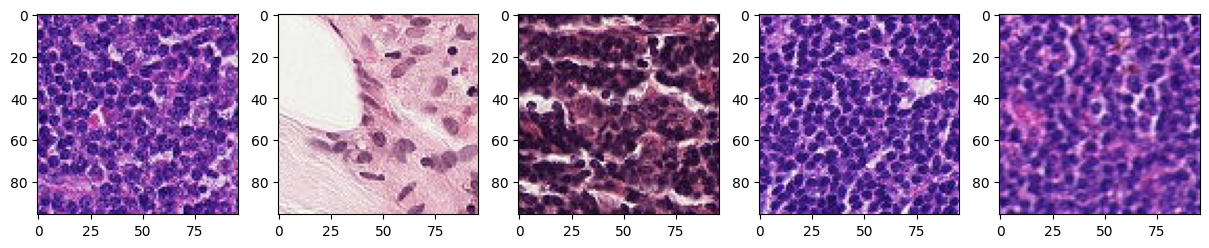

In [6]:
plt.figure()
f, ax = plt.subplots(1,n,figsize=(15,15))

for i in range(n):
    ax[i].imshow(sample_neg[i])

Here are 5 random positive images:

<Figure size 640x480 with 0 Axes>

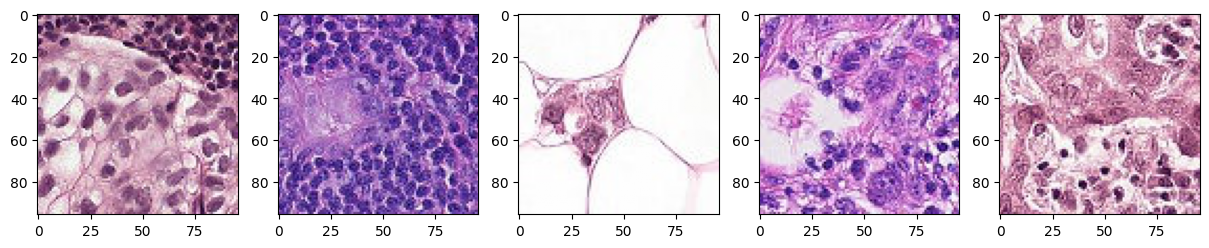

In [7]:
plt.figure()
f, ax = plt.subplots(1,n,figsize=(15,15))

for i in range(n):
    ax[i].imshow(sample_pos[i])

Without any training, I don't immediately notice any distinguishable characteristics between the upper and lower images. The negative images seem to be a bit more dense than the positive images, and perhaps there is more variation in the positive images, but it is difficult to identify any specific features that are indicative of cancer. A Convolutional Neural Network (CNN) trained on a large dataset will be able to extract these features.

First, to explore the data further and check for anomalies, I will plot a few basic features. For each image, I will calculate the average and standard deviation of the normalized pixel values:

In [8]:
imgs = read_images(data, "train")

imgs_grey = np.linalg.norm(imgs/np.sqrt(3), axis=3)
data['avg_magnitude'] = np.mean(imgs_grey, axis=(1,2))
data['std_dev'] = np.std(imgs_grey, axis=(1,2))

In [9]:
data.head()

,id,label,avg_magnitude,std_dev
8985,649f39ddab8372cd0943bc80c369568cd26d60f1,0,0.833627,0.085681
59233,fb73fd9c83792db79f753eea43c7137e434c078c,1,0.698150,0.203334
59333,faf1313b33e75a91fec57b053b6ed7332192298b,1,0.523174,0.106559
126614,82842a361258d93a8e42507ba255ca32bfbdbc4a,1,0.880497,0.134488
137933,d9c2e9fefe12e53b13c5b941531d801863103e03,0,0.402487,0.109434


Below is a histogram of the average pixel magnitude for negative and positive images. Interestingly, the values for the positive images appear to be normally distributed, while for the negative images, there are two large peaks. A large majority of images with an average pixel magnitude above 0.8 are negative for cancer.

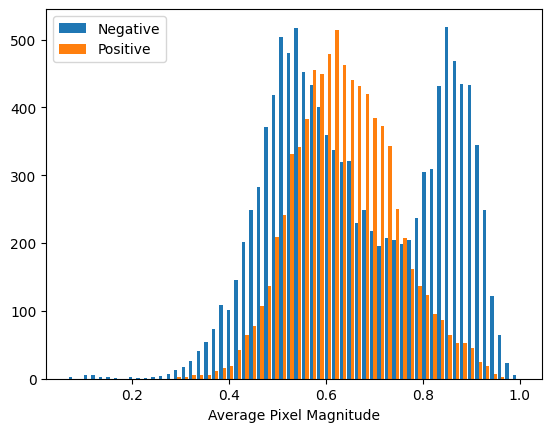

In [10]:
avg0 = data[data['label'] == 0]['avg_magnitude'].to_list()
avg1 = data[data['label'] == 1]['avg_magnitude'].to_list()

plt.hist([avg0, avg1], bins=60, label=['Negative','Positive'], rwidth=0.9)
plt.legend()
plt.xlabel('Average Pixel Magnitude')
plt.show()

Here is a histogram of the standard deviation of pixel values. Again, the positive images have a normal distribution, while the negative images have an irregular one. Almost all images with a standard deviation below 0.1 are negative.

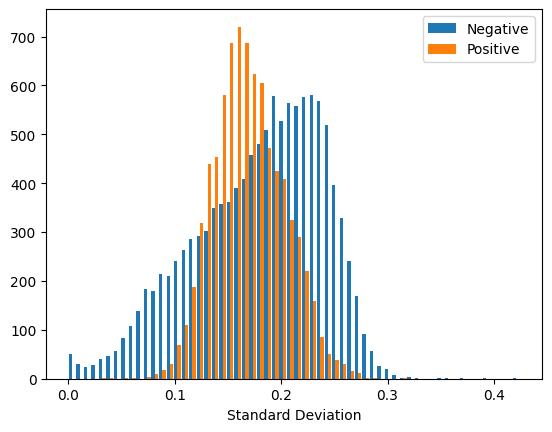

In [11]:
sd0 = data[data['label'] == 0]['std_dev'].to_list()
sd1 = data[data['label'] == 1]['std_dev'].to_list()

plt.hist([sd0, sd1], bins=60, label=['Negative','Positive'], rwidth=0.9)
plt.legend()
plt.xlabel('Standard Deviation')
plt.show()

Here is a scatterplot of the average magnitude and standard deviation. There are surprisingly distinct regions for negative and positive images, although there is a large area of overlap as well.

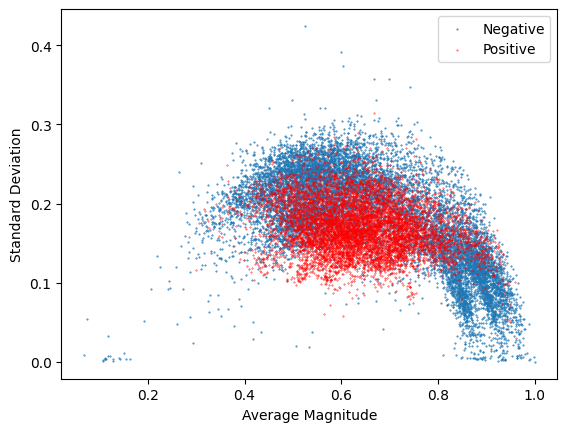

In [12]:
plt.scatter(avg0,sd0,s=0.2,label='Negative')
plt.scatter(avg1,sd1,color='Red',s=0.1,label='Positive')
plt.xlabel('Average Magnitude')
plt.ylabel('Standard Deviation')
plt.legend()

I want to take a closer look at the images with large magnitude and small standard deviations. Looking at a sample of these images, they appear to be almost completely blank, and obviously not medically useful. Fortunately, these are a tiny fraction of images in the dataset, so it should not have a large effect on the CNN training.

/tmp/ipykernel_7918/2878818071.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = read_images(data[data['label'] == 0][data['avg_magnitude'] > 0.8][data['std_dev'] < 0.01].sample(n), "train")
/tmp/ipykernel_7918/2878818071.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = read_images(data[data['label'] == 0][data['avg_magnitude'] > 0.8][data['std_dev'] < 0.01].sample(n), "train")


<Figure size 640x480 with 0 Axes>

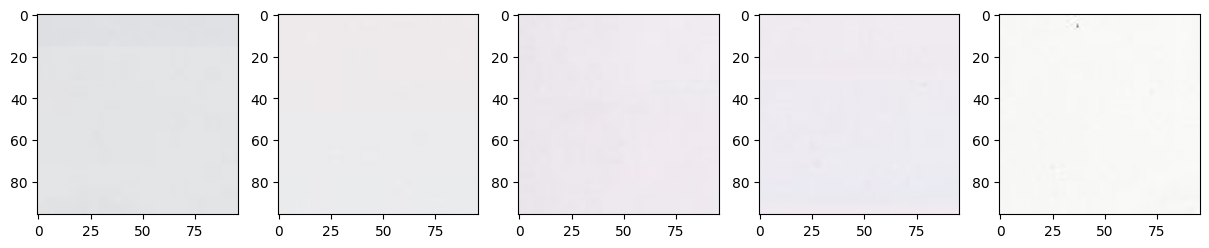

In [13]:
sample = read_images(data[data['label'] == 0][data['avg_magnitude'] > 0.8][data['std_dev'] < 0.01].sample(n), "train")

plt.figure()
f, ax = plt.subplots(1,n,figsize=(15,15))

for i in range(n):
    ax[i].imshow(sample[i])

### Model Building and Results

Before training the model, I will split my data into a training set and a validation set. I will use 16,000 images for training and save 4,000 for validation.

In [14]:
M = int(0.8*N)

train_data = data[:M]
val_data = data[M:]

train_imgs = read_images(train_data, "train")
val_imgs = read_images(val_data, "train")

print(train_imgs.shape)
print(val_imgs.shape)

train_labels = train_data['label'].to_numpy()
val_labels = val_data['label'].to_numpy()

(16000, 96, 96, 3)
(4000, 96, 96, 3)


The first model I will try is a Convolutional Neural Network that uses a repeated sequence of a 3x3 convolution layer followed by a 2x2 max pooling layer. It includes one dense neural network layer after the image dimensions shrink to 6x6. The number of filters doubles after each max pooling layer. With this model, I intend to take the most conventional approach to CNN architecture as outlined in course material and online sources.

As specified in the Kaggle challenge, the model should produce a probability value between 0 and 1 of each image containing malignant cancer cells, and the metric for evaluation will be the area under the ROC curve. Therefore, I will use a sigmoid activation function for the last layer and a binary_crossentropy loss function. 

In [15]:
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), padding='same'))
model1.add(layers.MaxPooling2D((2, 2))) #Output: (48, 48, 32)

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2))) #Output: (24, 24, 64) 

model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2))) #Output: (12, 12, 128)

model1.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2))) #Output: (6, 6, 256)

model1.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model1.add(layers.Flatten()) #Output: (1, 1, 18,432)

model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

model1.summary()


/home/edejongh/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742939747.045260    7918 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-25 16:55:47.062377: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for y

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,748,353 (10.48 MB)

 Trainable params: 2,748,353 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
fitted_model1 = model1.fit(train_imgs, train_labels, epochs=20, 
                        validation_data=(val_imgs, val_labels))

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 151ms/step - AUC: 0.7098 - loss: 0.6037 - val_AUC: 0.8502 - val_loss: 0.4966
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 151ms/step - AUC: 0.8579 - loss: 0.4587 - val_AUC: 0.8967 - val_loss: 0.3958
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - AUC: 0.8808 - loss: 0.4256 - val_AUC: 0.8869 - val_loss: 0.4419
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - AUC: 0.8838 - loss: 0.4156 - val_AUC: 0.9133 - val_loss: 0.3699
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - AUC: 0.9073 - loss: 0.3751 - val_AUC: 0.8987 - val_loss: 0.3978
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - AUC: 0.9116 - loss: 0.3680 - val_AUC: 0.9015 - val_loss: 0.4004
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - AUC: 0.9235 - loss: 0.3419 - val_AUC: 0.9288 - val_loss: 0.3332
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - AUC: 0.9351 - loss: 0.3176 - val_AUC: 0.9224 - val_loss: 0.3521
Epoch 9/20
500/500 ━━━━━━━━━━━━━

The first hyperparamater to tune for this model is the number of epochs. The plot below shows the AUC (area under curve) for the training data and validation data at each epoch. In this case, the AUC for the validation data peaked at 0.933 at the 9th epoch.

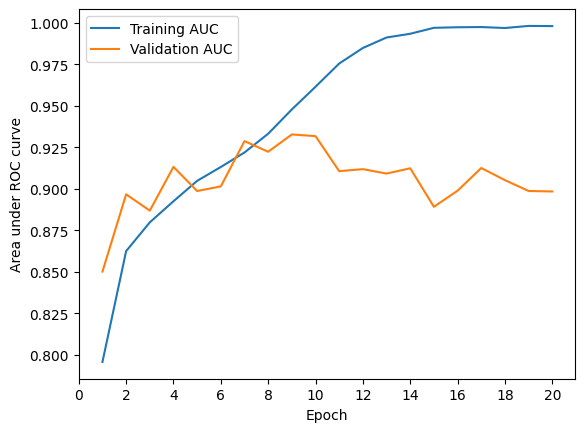

Best Epoch: 9, AUC = 0.9328320622444153


In [17]:
def plot_history(fitted_model):
    train_auc = fitted_model.history['AUC']
    val_auc = fitted_model.history['val_AUC']

    n = len(train_auc)
    epoch = range(1, n+1)

    plt.plot(epoch, train_auc, label='Training AUC')
    plt.plot(epoch, val_auc, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Area under ROC curve')
    plt.legend()
    plt.xticks(range(0, n+1, 2))
    plt.show()

def Best_AUC(fitted_model):
    best_auc = 0
    best_epoch = 0
    val_auc = fitted_model.history['val_AUC']
    
    for i in range(len(val_auc)):
        if val_auc[i] > best_auc:
            best_auc = val_auc[i]
            best_epoch = i+1

    print("Best Epoch: " + str(best_epoch) + ", AUC = " + str(best_auc))

plot_history(fitted_model1)
Best_AUC(fitted_model1)

Next, I will run a paramter sweep for two hyperparameters: the dropout layer fraction (0.0, 0.2, or 0.4) and the batch size (16, 64, or 128). The results below show the best validation AUC for each combination of parameters.

In [18]:
dropout_params=[0.0, 0.2, 0.4]
batch_size=[16, 64, 128]

model_list = []
for d in dropout_params:
    for b in batch_size:
        
        model = models.Sequential()

        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), padding='same'))
        model.add(layers.MaxPooling2D((2, 2))) #Output: (48, 48, 32)

        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2))) #Output: (24, 24, 64) 

        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2))) #Output: (12, 12, 128)

        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2))) #Output: (6, 6, 256)

        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Flatten()) #Output: (1, 1, 18,432)

        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(d))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
        model_list.append(model.fit(train_imgs, train_labels, epochs=15, 
                        validation_data=(val_imgs, val_labels), batch_size=b))


Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 77s 76ms/step - AUC: 0.6018 - loss: 0.6512 - val_AUC: 0.8452 - val_loss: 0.4913
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.8294 - loss: 0.4993 - val_AUC: 0.8688 - val_loss: 0.4416
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.8626 - loss: 0.4529 - val_AUC: 0.8806 - val_loss: 0.4404
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.8723 - loss: 0.4372 - val_AUC: 0.9017 - val_loss: 0.3867
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.8876 - loss: 0.4124 - val_AUC: 0.8971 - val_loss: 0.4012
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.9037 - loss: 0.3834 - val_AUC: 0.9052 - val_loss: 0.3835
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.9109 - loss: 0.3701 - val_AUC: 0.8985 - val_loss: 0.3959
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - AUC: 0.9161 - loss: 0.3587 - val_AUC: 0.9090 - val_loss: 0.4759
Epoch 9/15
1000/1000 ━━━

In [19]:
i = 0
for d in dropout_params:
    for b in batch_size:
        print("Dropout: " + str(d) + ", Batch Size: " + str(b))
        Best_AUC(model_list[i])
        i = i + 1    

Dropout: 0.0, Batch Size: 16
Best Epoch: 10, AUC = 0.9170979261398315
Dropout: 0.0, Batch Size: 64
Best Epoch: 10, AUC = 0.9357538819313049
Dropout: 0.0, Batch Size: 128
Best Epoch: 12, AUC = 0.9264370799064636
Dropout: 0.2, Batch Size: 16
Best Epoch: 10, AUC = 0.9204218983650208
Dropout: 0.2, Batch Size: 64
Best Epoch: 13, AUC = 0.9354884028434753
Dropout: 0.2, Batch Size: 128
Best Epoch: 13, AUC = 0.9383442997932434
Dropout: 0.4, Batch Size: 16
Best Epoch: 13, AUC = 0.9223700165748596
Dropout: 0.4, Batch Size: 64
Best Epoch: 13, AUC = 0.9380366802215576
Dropout: 0.4, Batch Size: 128
Best Epoch: 13, AUC = 0.9348757863044739


The best-performing model from this parameter sweep achieved a validation AUC of 0.938 - a small improvement from the first model - with a dropout fraction of 0.2 and a batch size of 128. These parameters don't seem to make a large difference on the result. Increasing the batch size (it was 32 for the default model) seems to help slightly, but at the cost of requiring more epochs (13) to reach the optimal result.

For the last model, I will try adding an additional 5x5 convolution layer before each 3x3 layer, as well as an additional dense neural network layer at the end. This signficant increases the total number of parameters in the model, from 2.7 million to 4.2 million.

In [20]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(96, 96, 3), padding='same'))
model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))  

model3.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(layers.MaxPooling2D((2, 2))) 

model3.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
model3.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

model3.add(layers.Flatten()) 

model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

model3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 96, 96, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 48, 48, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225,505 (16.12 MB)

 Trainable params: 4,225,505 (16.12 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
fitted_model3 = model3.fit(train_imgs, train_labels, epochs=20, 
                        validation_data=(val_imgs, val_labels), batch_size=128)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - AUC: 0.6196 - loss: 0.6467 - val_AUC: 0.8512 - val_loss: 0.5275
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - AUC: 0.8250 - loss: 0.5066 - val_AUC: 0.8653 - val_loss: 0.4623
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - AUC: 0.8402 - loss: 0.4834 - val_AUC: 0.8840 - val_loss: 0.4322
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - AUC: 0.8598 - loss: 0.4579 - val_AUC: 0.8951 - val_loss: 0.3999
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - AUC: 0.8740 - loss: 0.4366 - val_AUC: 0.8966 - val_loss: 0.4000
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - AUC: 0.8868 - loss: 0.4151 - val_AUC: 0.8805 - val_loss: 0.4248
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - AUC: 0.8931 - loss: 0.4027 - val_AUC: 0.9041 - val_loss: 0.4024
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - AUC: 0.9025 - loss: 0.3863 - val_AUC: 0.9025 - val_loss: 0.3975
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/

This more complex model achieved a peak validation AUC of 0.930, slightly worse than the less complex model above. The plot below shows a slightly more gradual training process in which the training AUC may still be increasing after 20 epochs, although the validation AUC appears to have peaked.

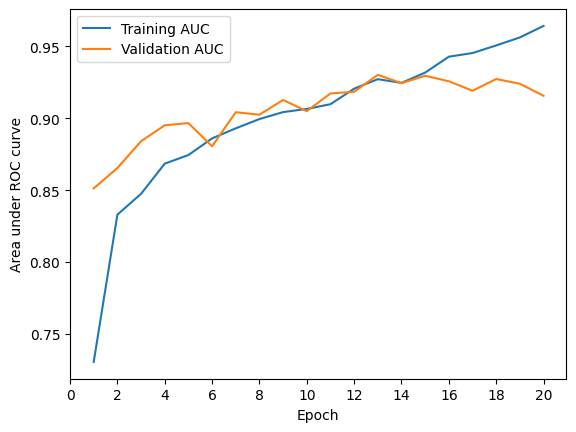

Best Epoch: 13, AUC = 0.9301354289054871


In [22]:
plot_history(fitted_model3)
Best_AUC(fitted_model3)

Since adding more layers did not improve the results, I will use the simpler, less computationally expensive model for the final results. As determined from the hyperparameter tuning process, I will use a dropout fraction of 0.2, a batch size of 128, and 13 epochs.

In [25]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2))) #Output: (48, 48, 32)

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2))) #Output: (24, 24, 64) 

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2))) #Output: (12, 12, 128)

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2))) #Output: (6, 6, 256)

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Flatten()) #Output: (1, 1, 18,432)

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.fit(train_imgs, train_labels, epochs=13, 
                        validation_data=(val_imgs, val_labels), batch_size=128)

/home/edejongh/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 612ms/step - AUC: 0.6862 - loss: 0.6221 - val_AUC: 0.8651 - val_loss: 0.4799
Epoch 2/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 611ms/step - AUC: 0.8581 - loss: 0.4598 - val_AUC: 0.8772 - val_loss: 0.4376
Epoch 3/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 611ms/step - AUC: 0.8636 - loss: 0.4496 - val_AUC: 0.8951 - val_loss: 0.4046
Epoch 4/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 609ms/step - AUC: 0.8756 - loss: 0.4348 - val_AUC: 0.8984 - val_loss: 0.4074
Epoch 5/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 605ms/step - AUC: 0.8795 - loss: 0.4276 - val_AUC: 0.8992 - val_loss: 0.3954
Epoch 6/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - AUC: 0.8958 - loss: 0.3988 - val_AUC: 0.9127 - val_loss: 0.3703
Epoch 7/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 613ms/step - AUC: 0.9023 - loss: 0.3861 - val_AUC: 0.9192 - val_loss: 0.3528
Epoch 8/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 614ms/step - AUC: 0.9140 - loss: 0.3631 - val_AUC: 0.9167 - val_loss: 0.3578
Epoch 9/13
125/125 ━━━━━━━━━━━━━

Here I will run the model on the validation data to generate probability values for the images containing malignant cancer cells. For the first 10 samples, the predictions align well with the labels:

In [27]:
val_data['prediction'] = model.predict(val_imgs)
val_data.head(10)

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


/tmp/ipykernel_7918/2591346898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['prediction'] = model.predict(val_imgs)


,id,label,avg_magnitude,std_dev,prediction
134277,93701ed2783896586775222a0077008301af5a41,1,0.598210,0.160412,0.980052
203657,936c3e5723e6d9266b301cccb2b3444fa4638c66,1,0.584505,0.104752,0.999994
70415,909f0b0723ffefbe86d84a6259471c20399bd212,0,0.368931,0.180159,0.010239
91475,bbd033601ab9aa9e33a687b94bfb604c49b66498,0,0.743040,0.159854,0.027736
20404,f180417da7fd225fbe72ff06b20ccfa55af47950,0,0.857395,0.126482,0.008417
207524,75f2c3b491da0534a5c875dcc530c8f5230837bc,1,0.557325,0.098917,0.936403
94409,3174911e383b84f02e5f209ad89a0238283f3df8,0,0.864397,0.195561,0.042800
68205,f2a03ffdad5b08727f42fc3bec25ccd8d67335f0,1,0.724378,0.139424,0.991301
8600,8caefcbf2178e45cc0b39ed7b9c750a830b25e16,1,0.607859,0.161727,0.985907
183430,28306ffccfd59fb60c374b607c99da5a594938ba,0,0.879929,0.101226,0.004398


### Discussion
Because the model generates probabilities of cancer rather than a binary prediction, a decision must be made about the probability threshold at which to determine that a potential cancer has been detected. This means striking a balance between maximizing the true positive rate (the percentage of positive cases that are marked positive) and minimizing the false positive rate (the percentage of negative cases that are marked positive). The first plot below shows the ROC curve - the relationship between the true positive rate and the false positive rate - for this model. The second plot shows how both relate to the probability threshold. These results suggest that in order to achieve a 95% true positive rate by marking everything with a probabilty above 5% as positive, one must be willing to accept a roughly 35% false positive rate. A 90% true positive rate corresponds to a roughly 20% false positive rate.

<Figure size 640x480 with 0 Axes>

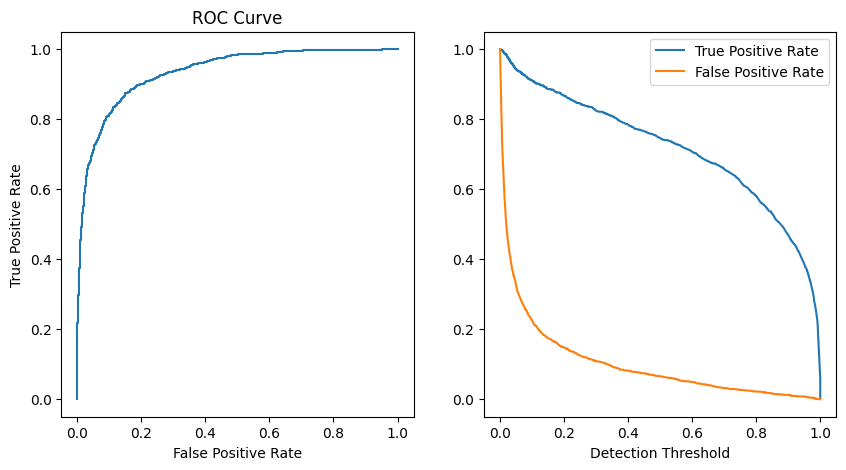

In [69]:
yt = val_data['label'].to_numpy()
yp = val_data['prediction'].to_numpy()

fpr, tpr, thresholds = roc_curve(yt, yp)

plt.figure()
f, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(fpr, tpr, label='ROC curve')
ax[0].set(xlabel = 'False Positive Rate')
ax[0].set(ylabel = 'True Positive Rate')
ax[0].set(title ='ROC Curve')

ax[1].plot(thresholds, tpr, label='True Positive Rate')
ax[1].plot(thresholds, fpr, label='False Positive Rate')
ax[1].set(xlabel = 'Detection Threshold')
ax[1].legend()
plt.show()

Here I will generate the predictions for the test data for the Kaggle submission.

In [23]:
test_data = pd.read_csv("sample_submission.csv")

test_imgs = read_images(test_data, "test")
test_imgs.shape

(57458, 96, 96, 3)

In [74]:
test_data['label'] = model.predict(test_imgs)
output = test_data.round(4)
output.head(10)

   2/1796 ━━━━━━━━━━━━━━━━━━━━ 4:07 138ms/step

2025-03-26 03:06:29.115229: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6354395136 exceeds 10% of free system memory.


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.0047
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.7712
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.0345
3,2c35657e312966e9294eac6841726ff3a748febf,0.0463
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.0355
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.6358
6,aa0307865281d4484ddf8c637c348292968b93a7,0.9859
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.3341
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.0096
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.8979


In [75]:
output.to_csv('output.csv')

### Conclusion

For this project, I successfully built and trained a Convolutional Neural Network model to evaluate microscopic images of lymph node tissue and predict the probability of them containing malignant cancer cells. I took a conventional approach to the model architecture and then made some small improvements through hyperparameter tuning. Adding additional layers to the model did not improve the results. Perhaps with more time and computing power, a more successful architecture can be developed. 

It is difficult to judge this model's performance without more information about the acceptable levels of true positive and false positive rates. It seems that it is difficult to achieve a very high true positive rate without accumulating a signifcant fraction of false positives. When it comes to detecting cancer, avoiding false negatives is paramount, however, false positives can also be harmful. Nevertheless, this project shows that Convolutional Neural Networks are a promising tool for fast processing and analysis of medical images.